### Imports

In [30]:
import matplotlib.pyplot as plt
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import math

from time import time

random.seed(10)

### Functions

In [14]:
def calculate_distance(p1, p2, alg_ver):
    if alg_ver:
        return math.sqrt((p2[0] - p1[0]) ** 2 + (p2[1] - p1[1]) ** 2)
    else:
        return abs(p2[0] - p1[0]) + abs(p2[1] - p1[1])

def calculate_score(distance, initial_distance):
    return abs( 1 - distance/initial_distance )

def create_chromosome(length):
    return list(np.random.choice(["n","s","w","e"], length))

def create_population(population_size, chromosome_length):
    population = []
    for i in range(population_size):
        population.append(create_chromosome(chromosome_length))
    return population

def fitness_function(chromosome, initial_distance, start_position, end_position, board, alg_ver):
    pos = start_position
    for move in chromosome:
        if move == "n":
            pos = (pos[0] - 1, pos[1])
        elif move == "s":
            pos = (pos[0] + 1, pos[1])
        elif move == "w":
            pos = (pos[0], pos[1] - 1)
        elif move == "e":
            pos = (pos[0], pos[1] + 1)
        
        if pos[0] == 0 or pos[1] == 0:
            return 0
        elif board[pos[0],pos[1]] == 1:
            return calculate_score(calculate_distance(pos, end_position, alg_ver), initial_distance)
        elif board[pos[0], pos[1]] == 3:
            return 1
    return calculate_score(calculate_distance(pos, end_position, alg_ver), initial_distance)

def score_population(population, initial_distance, start_position, end_position, board, alg_ver):
    population_scores = []
    for chromosome in population:
        population_scores.append(fitness_function(chromosome, initial_distance, start_position, end_position, board, alg_ver))
    return population_scores

def population_best_score(scores):
    return max(scores)

def population_average_score(scores):
    return sum(scores)/len(scores)

def take_elite(population, population_scores, elite_percentage):
    to_cut = int(elite_percentage * len(population))
    unsorted_list = list(zip(population, population_scores))
    sorted_list = list(sorted(unsorted_list, key=lambda x: x[1], reverse=True))
    return list(map(lambda x: x[0], sorted_list))[:to_cut]

def crossover_population(population):
    children = []
    list1 = population[:int(len(population)/2)]
    list2 = population[int(len(population)/2):]
    for i, j in zip(list1, list2):
        split_index = random.randint(0, len(i))
        child1 = i[0:split_index] + j[split_index:len(i)]
        child2 = j[0:split_index] + i[split_index:len(i)]
        children.append(child1)
        children.append(child2)
    return population + children

def mutate_population(population, mutation_chance):
    mutated_population = []
    for chromosome in population:
        if random.random() < mutation_chance:
            index_to_change = random.randint(0, len(chromosome) - 1)
            mutated_chromosome = chromosome
            mutated_chromosome[index_to_change] = np.random.choice(list(set(["n","s","w","e"]) - set(mutated_chromosome[index_to_change])))
            mutated_population.append(mutated_chromosome)
        else:
            mutated_population.append(chromosome)
    return mutated_population

def generate_path(board, chromosome, initial_position):
    board_copy = np.copy(board)
    pos = initial_position
    for move in chromosome:
        if move == "n":
            pos = (pos[0] - 1, pos[1])
        elif move == "s":
            pos = (pos[0] + 1, pos[1])
        elif move == "w":
            pos = (pos[0], pos[1] - 1)
        elif move == "e":
            pos = (pos[0], pos[1] + 1)
            
        if board[pos[0],pos[1]] == 1 or board[pos[0],pos[1]] == 3:
            return board_copy
        else:
            board_copy[pos[0], pos[1]] = 4
    return board_copy

def plot_generation_log(generation_log):
    generation = generation_log["generation"]
    average = generation_log["avg"]
    maximum = generation_log["max"]

    plt.plot(generation, average, label="average")
    plt.plot(generation, maximum, label="maximum")
    plt.xlabel("Generation")
    plt.ylabel("Fitness")
    plt.legend(loc="best")
    plt.show()
    
def show_result_board(board, chromosome, initial_position):
    result_board = generate_path(board, chromosome, initial_position)
    plt.imshow(result_board)
    plt.title("Best way")
    plt.show()
    
def show_statistics(hall_of_fame, generation_log):
    print(f"Fit: {round(hall_of_fame[1]*100)}%")
    print(f"Generations: {len(generation_log)}")
    
def evolutionary_algorithm(initial_size, 
                           chromosome_size, 
                           max_generations, 
                           initial_distance, 
                           position_start, 
                           position_end, 
                           board, 
                           elite_percentage, 
                           mutation_chance,
                           alg_ver):
    
    pop = create_population(initial_size, chromosome_size)
    generation_log_array = []
    list_of_bests = []
    
    for i in range(MAX_GENERATIONS):
        # score population
        fit = score_population(pop, initial_distance, position_start, position_end, board, alg_ver)

        # take strongest chromosomes
        pop = take_elite(pop, fit, elite_percentage)

        # calculate best chromosome from population
        best_chromosome = pop[0]
        best_score = fitness_function(best_chromosome, initial_distance, position_start, position_end, board, alg_ver)
        generation_log_array.append((i, len(pop), best_score, population_average_score(fit)))
        list_of_bests.append((best_chromosome, best_score))

        # break if reach 1
        if best_score == 1:
            break

        #crossover
        pop = crossover_population(pop)

        #mutate
        pop = mutate_population(pop, mutation_chance)

    hall_of_fame = max(list_of_bests, key = lambda x: x[1])
    generation_log = pd.DataFrame(generation_log_array, columns=["generation", "population_size", "max", "avg"])
    
    return hall_of_fame, generation_log

### Algorithm parameters

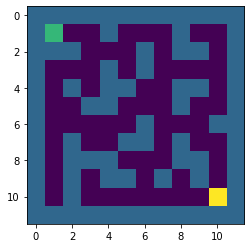

In [15]:
BOARD = np.array([
    [1,1,1,1,1,1,1,1,1,1,1,1],
    [1,2,0,0,1,0,0,0,1,0,0,1],
    [1,1,1,0,0,0,1,0,1,1,0,1],
    [1,0,0,0,1,0,1,0,0,0,0,1],
    [1,0,1,0,1,1,0,0,1,1,0,1],
    [1,0,0,1,1,0,0,0,1,0,0,1],
    [1,0,0,0,0,0,1,0,0,0,1,1],
    [1,0,1,0,0,1,1,0,1,0,0,1],
    [1,0,1,1,1,0,0,0,1,1,0,1],
    [1,0,1,0,1,1,0,1,0,1,0,1],
    [1,0,1,0,0,0,0,0,0,0,3,1],
    [1,1,1,1,1,1,1,1,1,1,1,1]
])
plt.imshow(BOARD)
plt.show()

CHROMOSOME_SIZE = 40
POSITION_START = (1,1)
POSITION_END = (10,10)
INITIAL_DISTANCE = calculate_distance(POSITION_START, POSITION_END, 0)
INITIAL_SIZE = 500
MAX_GENERATIONS = 2000
ELITE_PERCENTAGE = 0.5
MUTATION_CHANCE = 0.1

### Running the algorithm

In [16]:
hall_of_fame, generation_log = evolutionary_algorithm(INITIAL_SIZE,
                                                      CHROMOSOME_SIZE,
                                                      MAX_GENERATIONS,
                                                      INITIAL_DISTANCE,
                                                      POSITION_START,
                                                      POSITION_END,
                                                      BOARD,
                                                      ELITE_PERCENTAGE,
                                                      MUTATION_CHANCE,
                                                      0)

### Algorithm statistics

Fit: 100%
Generations: 72


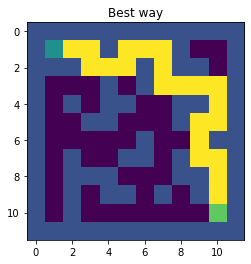

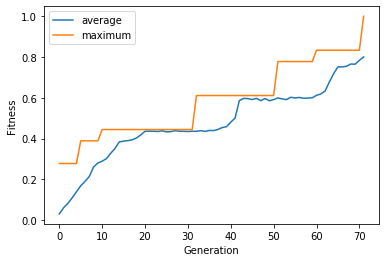

In [17]:
show_statistics(hall_of_fame, generation_log)
show_result_board(BOARD, hall_of_fame[0], POSITION_START)
plot_generation_log(generation_log)

### Generation log

In [18]:
print(generation_log)

    generation  population_size       max       avg
0            0              250  0.277778  0.030556
1            1              250  0.277778  0.060556
2            2              250  0.277778  0.082222
3            3              250  0.277778  0.109222
4            4              250  0.277778  0.139111
..         ...              ...       ...       ...
67          67              250  0.833333  0.754444
68          68              250  0.833333  0.765667
69          69              250  0.833333  0.764778
70          70              250  0.833333  0.783778
71          71              250  1.000000  0.800444

[72 rows x 4 columns]


### Breadth-first search

In [19]:
def possible_moves(board, point, visited):
    stack = []
    if (board[point[0] - 1, point[1]] == 0 or board[point[0] - 1, point[1]] == 3) and (point[0] - 1, point[1]) not in visited:
        stack.append("n")
    if (board[point[0] + 1, point[1]] == 0 or board[point[0] + 1, point[1]] == 3)  and (point[0] + 1, point[1]) not in visited:
        stack.append("s")
    if (board[point[0], point[1] - 1] == 0 or board[point[0], point[1] - 1] == 3)  and (point[0], point[1] - 1) not in visited:
        stack.append("w")
    if (board[point[0], point[1] + 1] == 0 or board[point[0], point[1] + 1] == 3)  and (point[0], point[1] + 1) not in visited:
        stack.append("e")
    return stack
    
        

def bfs(board, max_moves, point, stack=[], visited=[], iteration=0):
    if board[point[0],point[1]] == 3:
        return (stack, 1)
    moves = possible_moves(board, point, visited)
    if len(moves) == 0 or len(stack) > max_moves:
        return (stack, 0)
    moves_stack = []
    for move in moves:
        if   move == "n":
            way_n = bfs(board, max_moves, (point[0] - 1, point[1]), stack + ["n"], visited + [(point[0] - 1, point[1])], iteration + 1)
            moves_stack.append(way_n)
        elif move == "s":
            way_s = bfs(board, max_moves, (point[0] + 1, point[1]), stack + ["s"], visited + [(point[0] + 1, point[1])], iteration + 1)
            moves_stack.append(way_s)
        elif move == "w":
            way_w = bfs(board, max_moves, (point[0], point[1] - 1), stack + ["w"], visited + [(point[0], point[1] - 1)], iteration + 1)
            moves_stack.append(way_w)
        elif move == "e":
            way_e = bfs(board, max_moves, (point[0], point[1] + 1), stack + ["e"], visited + [(point[0], point[1] + 1)], iteration + 1)
            moves_stack.append(way_e)

    successful_paths = list(filter(lambda x: x[1] == 1, moves_stack))
    
    if len(successful_paths) == 0:
        return (moves_stack[0][0], 0)
    else:
        map_paths = list(map(lambda x: x[0], successful_paths))
        shortest_path = sorted(map_paths, key=len)[0]
        return (shortest_path, 1)

### BFS usage

Is successful:  True
['e', 'e', 's', 'e', 'e', 'n', 'e', 'e', 's', 's', 's', 's', 's', 'e', 'e', 's', 'e', 's', 's', 's']


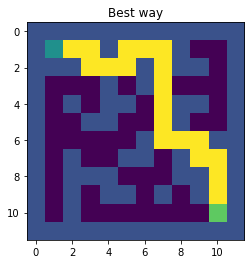

In [20]:
(path, status) = bfs(BOARD, CHROMOSOME_SIZE, POSITION_START)
print("Is successful: ", True if status else False)
print(path)
show_result_board(BOARD, path, POSITION_START)


### Experiment

In [39]:
BOARD = np.array([
    [1,1,1,1,1,1,1,1,1,1,1,1],
    [1,2,0,0,1,0,0,0,1,0,0,1],
    [1,1,1,0,0,0,1,0,1,1,0,1],
    [1,0,0,0,1,0,1,0,0,0,0,1],
    [1,0,1,0,1,1,0,0,1,1,0,1],
    [1,0,0,1,1,0,0,0,1,0,0,1],
    [1,0,0,0,0,0,1,0,0,0,1,1],
    [1,0,1,0,0,1,1,0,1,0,0,1],
    [1,0,1,1,1,0,0,0,1,1,0,1],
    [1,0,1,0,1,1,0,1,0,1,0,1],
    [1,0,1,0,0,0,0,0,0,0,3,1],
    [1,1,1,1,1,1,1,1,1,1,1,1]
])

POSITION_START = (1,1)
POSITION_END = (10,10)
INITIAL_DISTANCE = calculate_distance(POSITION_START, POSITION_END, 0)
ELITE_PERCENTAGE = 0.5
MAX_GENERATIONS = 2000

# evolutionary_algorithm - input 1 - fitness v1 --------------------------------------------------
CHROMOSOME_SIZE_1 = 30
INITIAL_SIZE_1 = 400
MUTATION_CHANCE_1 = 0.05

start1 = time()
HOF_1, _ = evolutionary_algorithm(INITIAL_SIZE_1,
                                  CHROMOSOME_SIZE_1,
                                  MAX_GENERATIONS,
                                  INITIAL_DISTANCE,
                                  POSITION_START,
                                  POSITION_END,
                                  BOARD,
                                  ELITE_PERCENTAGE,
                                  MUTATION_CHANCE_1,
                                  0)
end1 = time()
TIME_1 = (end1 - start1)

# evolutionary_algorithm - input 2 - fitness v1  --------------------------------------------------
CHROMOSOME_SIZE_2 = 60
INITIAL_SIZE_2 = 500
MUTATION_CHANCE_2 = 0.05

start2 = time()
HOF_2, _ = evolutionary_algorithm(INITIAL_SIZE_2,
                                  CHROMOSOME_SIZE_2,
                                  MAX_GENERATIONS,
                                  INITIAL_DISTANCE,
                                  POSITION_START,
                                  POSITION_END,
                                  BOARD,
                                  ELITE_PERCENTAGE,
                                  MUTATION_CHANCE_2,
                                  0)
end2 = time()
TIME_2 = (end2 - start2)

# evolutionary_algorithm - input 3 fitness v1 --------------------------------------------------
CHROMOSOME_SIZE_3 = 90
INITIAL_SIZE_3 = 800
MUTATION_CHANCE_3 = 0.1

start3 = time()
HOF_3, _ = evolutionary_algorithm(INITIAL_SIZE_3,
                                  CHROMOSOME_SIZE_3,
                                  MAX_GENERATIONS,
                                  INITIAL_DISTANCE,
                                  POSITION_START,
                                  POSITION_END,
                                  BOARD,
                                  ELITE_PERCENTAGE,
                                  MUTATION_CHANCE_3,
                                  0)
end3 = time()
TIME_3 = (end3 - start3)

INITIAL_DISTANCE = calculate_distance(POSITION_START, POSITION_END, 1)

# evolutionary_algorithm - input 1 - fitness v2 --------------------------------------------------
CHROMOSOME_SIZE_1 = 30
INITIAL_SIZE_1 = 400
MUTATION_CHANCE_1 = 0.05

start7 = time()
HOF_7, _ = evolutionary_algorithm(INITIAL_SIZE_1,
                                  CHROMOSOME_SIZE_1,
                                  MAX_GENERATIONS,
                                  INITIAL_DISTANCE,
                                  POSITION_START,
                                  POSITION_END,
                                  BOARD,
                                  ELITE_PERCENTAGE,
                                  MUTATION_CHANCE_1,
                                  1)
end7 = time()
TIME_7 = (end7 - start7)

# evolutionary_algorithm - input 2 - fitness v2 --------------------------------------------------
CHROMOSOME_SIZE_2 = 60
INITIAL_SIZE_2 = 500
MUTATION_CHANCE_2 = 0.05

start8 = time()
HOF_8, _ = evolutionary_algorithm(INITIAL_SIZE_2,
                                  CHROMOSOME_SIZE_2,
                                  MAX_GENERATIONS,
                                  INITIAL_DISTANCE,
                                  POSITION_START,
                                  POSITION_END,
                                  BOARD,
                                  ELITE_PERCENTAGE,
                                  MUTATION_CHANCE_2,
                                  1)
end8 = time()
TIME_8 = (end8 - start8)

# evolutionary_algorithm - input 3 - fitness v2 --------------------------------------------------
CHROMOSOME_SIZE_3 = 90
INITIAL_SIZE_3 = 1000
MUTATION_CHANCE_3 = 0.1

start9 = time()
HOF_9, _ = evolutionary_algorithm(INITIAL_SIZE_3,
                                  CHROMOSOME_SIZE_3,
                                  MAX_GENERATIONS,
                                  INITIAL_DISTANCE,
                                  POSITION_START,
                                  POSITION_END,
                                  BOARD,
                                  ELITE_PERCENTAGE,
                                  MUTATION_CHANCE_3,
                                  1)
end9 = time()
TIME_9 = (end9 - start9)


# breadth-first search - input 1 ----------------------------------------------------
MAX_MOVES_4 = 30

start4 = time()
(_, STATUS_4) = bfs(BOARD, MAX_MOVES_4 , POSITION_START)
end4 = time()
TIME_4 = (end4 - start4)

# breadth-first search - input 2 ----------------------------------------------------
MAX_MOVES_5 = 60

start5 = time()
(_, STATUS_5) = bfs(BOARD, MAX_MOVES_5 , POSITION_START)
end5 = time()
TIME_5 = (end5 - start5)

# breadth-first search - input 3 ----------------------------------------------------
MAX_MOVES_6 = 90

start6 = time()
(_, STATUS_6) = bfs(BOARD, MAX_MOVES_6 , POSITION_START)
end6 = time()
TIME_6 = (end6 - start6)

In [40]:
print("--- evolutionary_algorithm - 30 elements - fitness v1 ---")
print(f"{round(TIME_1, 3)}s")
print(HOF_1[1])

print("--- evolutionary_algorithm - 60 elements - fitness v1 ---")
print(f"{round(TIME_2, 3)}s")
print(HOF_2[1])

print("--- evolutionary_algorithm - 90 elements - fitness v1 ---")
print(f"{round(TIME_3, 3)}s")
print(HOF_3[1])

print("--- evolutionary_algorithm - 30 elements - fitness v2 ---")
print(f"{round(TIME_7, 3)}s")
print(HOF_7[1])

print("--- evolutionary_algorithm - 60 elements - fitness v2 ---")
print(f"{round(TIME_8, 3)}s")
print(HOF_8[1])

print("--- evolutionary_algorithm - 90 elements - fitness v2 ---")
print(f"{round(TIME_9, 3)}s")
print(HOF_9[1])

print("--- breadth-first search - 30 elements ---")
print(f"{round(TIME_4, 3)}s")
print(STATUS_4)

print("--- breadth-first search - 60 elements ---")
print(f"{round(TIME_5, 3)}s")
print(STATUS_5)

print("--- breadth-first search - 90 elements ---")
print(f"{round(TIME_6, 3)}s")
print(STATUS_6)

--- evolutionary_algorithm - 30 elements - fitness v1 ---
1.172s
1
--- evolutionary_algorithm - 60 elements - fitness v1 ---
6.686s
1
--- evolutionary_algorithm - 90 elements - fitness v1 ---
7.925s
1
--- evolutionary_algorithm - 30 elements - fitness v2 ---
20.093s
0.8428651597363228
--- evolutionary_algorithm - 60 elements - fitness v2 ---
9.326s
1
--- evolutionary_algorithm - 90 elements - fitness v2 ---
8.829s
1
--- breadth-first search - 30 elements ---
0.006s
1
--- breadth-first search - 60 elements ---
0.007s
1
--- breadth-first search - 90 elements ---
0.008s
1


|                              | Input size: 30  | Input size: 60     | Input size: 90     |
|------------------------------|-----------------|--------------------|--------------------|
| Genetic algorithm fitness v1 | 1.172s          | 6.686s             | 7.925s             |
| Genetic algorithm fitness v2 | 20.093s <br />(84.2%)| 9.326s        | 8.829s             |
| breadth-first search         | 0.006s          | 0.007s             | 0.008s             |

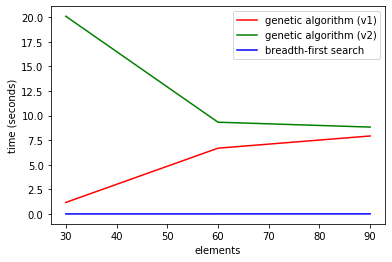

In [54]:
df=pd.DataFrame({
    'input size': [30,60,90], 
    'gaf1': [TIME_1, TIME_2, TIME_3],
    'gaf2': [TIME_7, TIME_8, TIME_9], 
    'bfs': [TIME_4, TIME_5, TIME_6]})
 
plt.plot( 'input size', 'gaf1', data=df, color='red', label="genetic algorithm (v1)")
plt.plot( 'input size', 'gaf2', data=df, color='green', label="genetic algorithm (v2)")
plt.plot( 'input size', 'bfs', data=df, color='blue', label="breadth-first search")
plt.xlabel("elements")
plt.ylabel("time (seconds)")
plt.legend()
plt.show()